# Multi-objective optimization with Expected HyperVolume Improvement

In [1]:
import math
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from util.plotting import plot_bo_points, plot_function_2d, plot_mobo_history, plot_mobo_points_in_obj_space

In [2]:
import trieste
from trieste.acquisition.function import ExpectedHypervolumeImprovement
from trieste.data import Dataset
from trieste.models import create_model
from trieste.models.model_interfaces import ModelStack
from trieste.space import Box
from trieste.utils.multi_objectives import VLMOP2
from trieste.utils.pareto import Pareto, get_reference_point
from trieste.acquisition.rule import EfficientGlobalOptimization

np.random.seed(1793)
tf.random.set_seed(1793)

## Describe the problem

In this tutorial, we provide a multi-objective optimization example using the expected hypervolume improvement acquisition function.
We consider the VLMOP2 function --- a synthetic benchmark problem with two objectives. We start by defining the problem parameters.

In [3]:
vlmop2 = VLMOP2().objective()
observer = trieste.utils.objectives.mk_observer(vlmop2)

In [4]:
mins = [-2, -2]
maxs = [2, 2]
search_space = Box(mins, maxs)
num_objective = 2

Let's randomly sample some initial data from the observer ...

In [5]:
num_initial_points = 20
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

... and visualise the data across the design space: each figure contains the contour lines of each objective function.

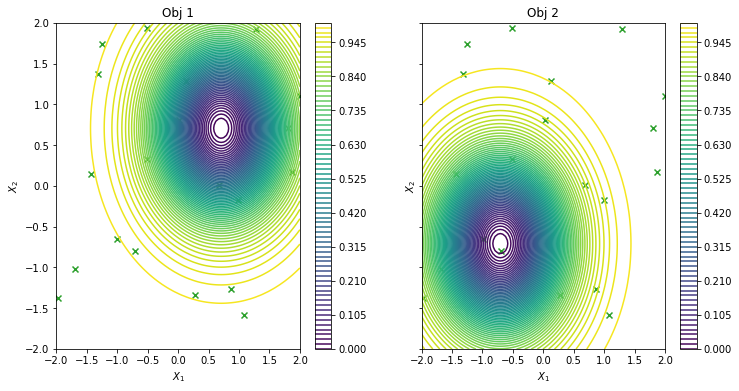

In [6]:
_, ax = plot_function_2d(
    vlmop2,
    mins,
    maxs,
    grid_density=100,
    contour=True,
    title=["Obj 1", "Obj 2"],
    figsize=(12, 6),
    colorbar=True,
    xlabel="$X_1$",
    ylabel="$X_2$",
)
plot_bo_points(initial_query_points, ax=ax[0, 0], num_init=num_initial_points)
plot_bo_points(initial_query_points, ax=ax[0, 1], num_init=num_initial_points)
plt.show()

... and in the objective space. The `plot_mobo_points_in_obj_space` will automatically search for non-dominated points and colours them in purple. 

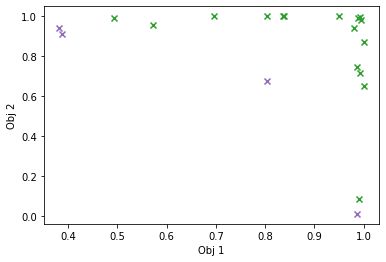

In [7]:
plot_mobo_points_in_obj_space(initial_data.observations)
plt.show()

## Modelling the two functions

In this example we model the two objective functions individually with their own Gaussian process models, for problems where the objective functions are similar it may make sense to build a joint model. 

We use a model wrapper: `ModelStack` to stack these two independent GP into a single model working as a (independent) multi-output model. 

In [8]:
def build_stacked_independent_objectives_model(data: Dataset, num_output) -> ModelStack:
        gprs =[]
        for idx in range(num_output):
            single_obj_data = Dataset(data.query_points, tf.gather(data.observations, [idx], axis=1))
            variance = tf.math.reduce_variance(single_obj_data.observations)
            kernel = gpflow.kernels.Matern52(variance)
            gpr = gpflow.models.GPR((single_obj_data.query_points, single_obj_data.observations), kernel, noise_variance=1e-5)
            gpflow.utilities.set_trainable(gpr.likelihood, False)
            gprs.append((create_model({
            "model": gpr,
            "optimizer": gpflow.optimizers.Scipy(),
            "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)}}}), 1))

        return ModelStack(*gprs)

In [9]:
model = build_stacked_independent_objectives_model(initial_data, num_objective)

## Define the acquisition function
Here we utilize the [EHVI](https://link.springer.com/article/10.1007/s10898-019-00798-7): `ExpectedHypervolumeImprovement` acquisition function:

In [10]:
ehvi = ExpectedHypervolumeImprovement()
rule = EfficientGlobalOptimization(builder=ehvi)  # type: ignore

## Run the optimization loop

We can now run the optimization loop

In [11]:
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
result = bo.optimize(num_steps, initial_data, model, acquisition_rule=rule)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Optimization completed without errors


To conclude, we visualize the queried data across the design space.  
We represent the initial points as crosses and the points obtained by our optimization loop as dots. 

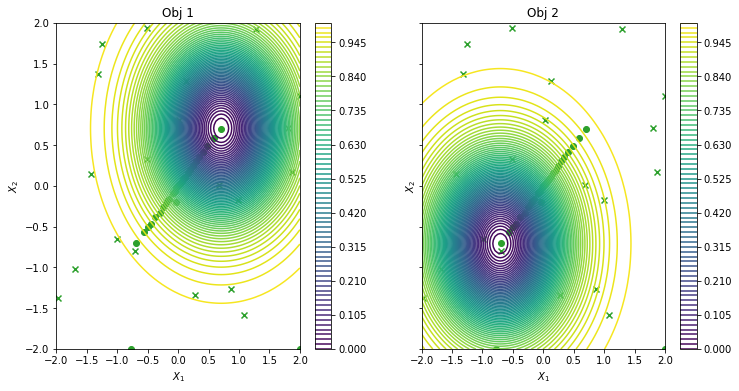

In [12]:
dataset = result.try_get_final_dataset()
data_query_points = dataset.query_points
data_observations = dataset.observations

_, ax = plot_function_2d(
    vlmop2,
    mins,
    maxs,
    grid_density=100,
    contour=True,
    figsize=(12, 6),
    title=["Obj 1", "Obj 2"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    colorbar=True,
)
plot_bo_points(data_query_points, ax=ax[0, 0], num_init=num_initial_points)
plot_bo_points(data_query_points, ax=ax[0, 1], num_init=num_initial_points)
plt.show()

Visualize in objective space. Purple dots denote the non-dominated points.

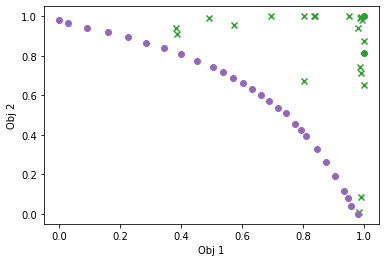

In [13]:
plot_mobo_points_in_obj_space(data_observations, num_init=num_initial_points)
plt.show()

We can also visualize how a performance metric evolved with respect to the number of BO iterations.
First, we need to define a performance metric. Many metrics have been considered for multi-objective optimization. Here, we use the log hypervolume difference, defined as the difference between the hypervolume of the actual Pareto front and the hypervolume of the approximate Pareto front based on the bo-obtained data.


$$
log_{10}\ \text{HV}_{\text{diff}} = log_{10}(\text{HV}_{\text{actual}} - \text{HV}_{\text{bo-obtained}})
$$


First we need to calculate the $\text{HV}_{\text{actual}}$ based on the actual Pareto front. For some multi-objective synthetic functions like VLMOP2, the actual Pareto front has a clear definition, thus we could use `gen_pareto_optimal_points` to near uniformly sample on the actual Pareto front. And use these generated Pareto optimal points to (approximately) calculate the hypervolume of the actual Pareto frontier:

In [14]:
actual_pf = VLMOP2().gen_pareto_optimal_points(100)  # gen 100 pf points
ref_point = get_reference_point(data_observations)
idea_hv = Pareto(tf.cast(actual_pf, dtype=data_observations.dtype)).hypervolume_indicator(ref_point)

Then we define the metric function:

In [15]:
def log_hv(observations):
    obs_hv = Pareto(observations).hypervolume_indicator(ref_point)
    return math.log10(idea_hv - obs_hv)

Finally, we can plot the convergence of our performance metric over the course of the optimization.  
The blue vertical line in the figure denotes the time after which BO starts.

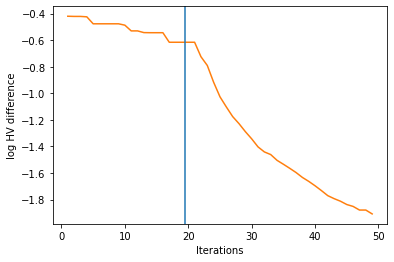

In [16]:
fig, ax = plot_mobo_history(data_observations, log_hv, num_init=num_initial_points)
ax.set_xlabel("Iterations")
ax.set_ylabel("log HV difference")
plt.show()

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)